<a href="https://colab.research.google.com/github/Tathira123/Assessment3/blob/main/ISY_503_Assessment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2018 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#Intro to Modeling


**Learning Objectives:**
* Become familiar with pandas for handling small datasets
* Use the tf.Estimator and Feature Column API to experiment with feature transformations
* Use visualizations and run experiments to understand the value of feature transformations

Please **make a copy** of this Colab notebook before starting this lab. To do so, choose **File**->**Save a copy in Drive**.

## Setup

Let's start by importing our dependencies.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf  # For TensorFlow 2.x, no need to disable v2 behavior

In [ ]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()  # Must be first TF command

## Pandas, a helpful data analysis library for in-memory dataset

We use a package called [Pandas](http://pandas.pydata.org/) for reading in our data, exploring our data and doing some basic processing. It is really helpful for datasets that fit in memory! And it has some nice integrations, as you will see.

First we set up some options to control how items are displayed and the maximum number of rows to show when displaying a table.  Feel free to change this setup to whatever you'd like.

In [ ]:
# Set pandas output display to have one digit for decimal places and limit it to
# printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

### Load the dataset with pandas
The car data set we will be using in this lab is provided as a comma separated file without a header row.  In order for each column to have a meaningful header name we must provide it.  We get the information about the columns from the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile).

We will use the features of the car, to try to predict its price.


In [ ]:
# Provide the names for the columns since the CSV file with the data does
# not have a header row.
feature_names = ['symboling', 'normalized-losses', 'make', 'fuel-type',
        'aspiration', 'num-doors', 'body-style', 'drive-wheels',
        'engine-location', 'wheel-base', 'length', 'width', 'height', 'weight',
        'engine-type', 'num-cylinders', 'engine-size', 'fuel-system', 'bore',
        'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
        'highway-mpg', 'price']


# Load in the data from a CSV file that is comma separated.
car_data = pd.read_csv('https://storage.googleapis.com/mledu-datasets/cars_data.csv',
                        sep=',', names=feature_names, header=None, encoding='latin-1')


# We'll then randomize the data, just to be sure not to get any pathological
# ordering effects that might harm the performance of Stochastic Gradient
# Descent.
car_data = car_data.reindex(np.random.permutation(car_data.index))

print("Data set loaded. Num examples: ", len(car_data))

Data set loaded. Num examples:  205


This is a really small dataset! Only 205 examples.

For simplicity in this codelab, we do not split the data further into training and validation. But you MUST do this on real datasets, or else you will overfit to your single dataset.

## Task 0: Use pandas to explore and prepare the data

- Use Pandas to inspect the data and manually curate a list of numeric_feature_names and categorical_feature_names.


Useful functions:
- `type()` called on any Python object describes the type of the object
- `dataframe[4:7]` pulls out rows 4, 5, 6 in a Pandas dataframe
- `dataframe[['mycol1', 'mycol2']]` pulls out the two requested columns into a new Pandas dataframe
- `dataframe['mycol1']` returns a Pandas series -- not a dataframe!
- `dataframe.describe()` prints out statistics for each dataframe column

In [ ]:
car_data[4:7]

,symboling,normalized-losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.50,...,152,mpfi,2.68,3.47,9.00,154,5000,19,26,16500
127,3,?,porsche,gas,std,two,hardtop,rwd,rear,89.50,...,194,mpfi,3.74,2.90,9.50,207,5900,17,25,34028
120,1,154,plymouth,gas,std,four,hatchback,fwd,front,93.70,...,90,2bbl,2.97,3.23,9.40,68,5500,31,38,6229


In [ ]:
# Provide the names for the columns since the CSV file with the data does
# not have a header row.
feature_names = ['symboling', 'normalized-losses', 'make', 'fuel-type',
        'aspiration', 'num-doors', 'body-style', 'drive-wheels',
        'engine-location', 'wheel-base', 'length', 'width', 'height', 'weight',
        'engine-type', 'num-cylinders', 'engine-size', 'fuel-system', 'bore',
        'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
        'highway-mpg', 'price']

LABEL = 'price'

# Define numeric_feature_names as a list of strings
numeric_feature_names = ['symboling', 'normalized-losses', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-size', 'horsepower',
        'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke',
         'compression-ratio']

# Calculate categorical_feature_names based on numeric_feature_names and LABEL
categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))

# Assertions to check the lengths of the lists
assert len(numeric_feature_names) == 15  # This assertion should now pass
assert len(categorical_feature_names) == 10

In [ ]:
# Run to inspect numeric features.
car_data[numeric_feature_names]

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,horsepower,peak-rpm,city-mpg,highway-mpg,bore,stroke,compression-ratio
160,0,91,95.70,166.30,64.40,53.00,2094,98,70,4800,38,47,3.19,3.03,9.00
117,0,161,108.00,186.70,68.30,56.00,3130,134,142,5600,18,24,3.61,3.21,7.00
134,3,150,99.10,186.60,66.50,56.10,2707,121,110,5250,21,28,2.54,2.07,9.30
103,0,108,100.40,184.60,66.50,55.10,3060,181,152,5200,19,25,3.43,3.27,9.00
2,1,?,94.50,171.20,65.50,52.40,2823,152,154,5000,19,26,2.68,3.47,9.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,1,125,96.30,172.40,65.40,51.60,2403,110,116,5500,23,30,3.17,3.46,7.50
129,1,?,98.40,175.70,72.30,50.50,3366,203,288,5750,17,28,3.94,3.11,10.00
3,2,164,99.80,176.60,66.20,54.30,2337,109,102,5500,24,30,3.19,3.40,10.00
163,1,168,94.50,168.70,64.00,52.60,2169,98,70,4800,29,34,3.19,3.03,9.00


In [ ]:
# Run to inspect categorical features.
car_data[categorical_feature_names]

,body-style,drive-wheels,num-cylinders,engine-location,fuel-type,engine-type,aspiration,make,fuel-system,num-doors
160,sedan,fwd,four,front,gas,ohc,std,toyota,2bbl,four
117,sedan,rwd,four,front,gas,l,turbo,peugot,mpfi,four
134,hatchback,fwd,four,front,gas,ohc,std,saab,mpfi,two
103,sedan,fwd,six,front,gas,ohcv,std,nissan,mpfi,four
2,hatchback,rwd,six,front,gas,ohcv,std,alfa-romero,mpfi,two
...,...,...,...,...,...,...,...,...,...,...
87,sedan,fwd,four,front,gas,ohc,turbo,mitsubishi,spdi,four
129,hatchback,rwd,eight,front,gas,dohcv,std,porsche,mpfi,two
3,sedan,fwd,four,front,gas,ohc,std,audi,mpfi,four
163,sedan,rwd,four,front,gas,ohc,std,toyota,2bbl,two


In [ ]:
# Coerce the numeric features to numbers. This is necessary because the model
# crashes because not all the values are numeric.
for feature_name in numeric_feature_names + [LABEL]:
  car_data[feature_name] = pd.to_numeric(car_data[feature_name], errors='coerce')

# Fill missing values with 0.
# Is this an OK thing to do? You may want to come back and revisit this decision later.
car_data.fillna(0, inplace=True)

## Task 1: Make your best model with numeric features. No normalization allowed.

Modify the model provided below to achieve the lowest eval loss. You may want to change various hyperparameters:
- learning rate
- choice of optimizer
- hidden layer dimensions -- make sure your choice here makes sense given the number of training examples
- batch size
- num training steps
- (anything else you can think of changing)

Do not use the `normalizer_fn` arg on `numeric_column`.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers

# Define batch size
batch_size = 16

# Prepare data
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create input function using TensorFlow Dataset
# Instead of using dict(x_df), pass x_df.values directly
train_dataset = tf.data.Dataset.from_tensor_slices((x_df.values, y_series))
train_dataset = train_dataset.batch(batch_size).repeat()  # Repeat dataset for multiple epochs

# Build a more complex DNN model using Keras with regularization
model = tf.keras.Sequential([
    tf.keras.Input(shape=(x_df.shape[1],)),  # Input layer (shape inferred from data)
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 Regularization
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 Regularization
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 Regularization
    layers.Dense(1)  # Output layer for regression
])

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(
    x_df.values, y_series.values,  # Ensure input is in numpy format
    epochs=100,  # Set epochs to 100
    batch_size=batch_size,
    validation_split=0.2,  # Use 20% of the data for validation
    callbacks=[early_stopping]  # Apply early stopping
)

# Evaluate the model on the test set
# Instead of using dict(x_df), pass x_df.values directly
eval_dataset = tf.data.Dataset.from_tensor_slices((x_df.values, y_series))
eval_dataset = eval_dataset.batch(batch_size)

# Evaluate the model
loss, mae = model.evaluate(eval_dataset, steps=len(x_df) // batch_size)

print(f"\n✅ Test MSE (Loss): {loss:.2f}")
print(f"✅ Test MAE: {mae:.2f}")

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 208105776.0000 - mae: 12018.7891 - val_loss: 176333456.0000 - val_mae: 10738.2617
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 160725584.0000 - mae: 10266.1484 - val_loss: 142585968.0000 - val_mae: 9133.8525
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 125942016.0000 - mae: 8704.1162 - val_loss: 107564184.0000 - val_mae: 7082.8862
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 113213048.0000 - mae: 7218.4346 - val_loss: 77143016.0000 - val_mae: 5215.1069
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 70666048.0000 - mae: 5485.7295 - val_loss: 61492204.0000 - val_mae: 5115.1987
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 68777672.0000 - mae: 5799.2905 - val_loss: 61385204.0000 - val_mae: 6115.2163
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 67691496.0000 - mae: 6181.0049 - val_loss: 61152100.0000 - val_mae: 6146.5771
Epoch 8/100
11/11 ━━━━━━━━

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers
import pandas as pd
from sklearn.model_selection import train_test_split

# Prepare the data for training and evaluation
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_df, y_series, test_size=0.2, random_state=42)

# Model 1: DNN (Deep Neural Network)
print("Training DNN (Deep Neural Network)...")
dnn_model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    layers.Dense(1)  # Output layer for regression
])

# Compile and train the DNN model
dnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  loss='mean_squared_error', metrics=['mae'])
dnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the DNN model
dnn_loss, dnn_mae = dnn_model.evaluate(X_test, y_test)
print("DNN Model Evaluation - Loss:", dnn_loss, "MAE:", dnn_mae)

# Model 2: Linear Regression (using Keras)
print("Training Linear Regression Model...")
linear_model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(1)  # Linear regression layer
])

# Compile and train the linear regression model
linear_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                     loss='mean_squared_error', metrics=['mae'])
linear_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the Linear Regression model
linear_loss, linear_mae = linear_model.evaluate(X_test, y_test)
print("Linear Regression Model Evaluation - Loss:", linear_loss, "MAE:", linear_mae)

# Model 3: Hybrid DNN + Linear Combined Regression (using Keras)
print("Training DNN + Linear Combined Model...")
combined_model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    layers.Dense(1)  # Output layer for regression
])

# Compile and train the combined model
combined_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                       loss='mean_squared_error', metrics=['mae'])
combined_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the DNN + Linear Combined model
combined_loss, combined_mae = combined_model.evaluate(X_test, y_test)
print("DNN + Linear Combined Model Evaluation - Loss:", combined_loss, "MAE:", combined_mae)


Training DNN (Deep Neural Network)...
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 193053248.0000 - mae: 10713.0908 - val_loss: 61747544.0000 - val_mae: 5061.7632
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 85839768.0000 - mae: 6592.6406 - val_loss: 71653040.0000 - val_mae: 7480.2622
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 71455872.0000 - mae: 6714.2998 - val_loss: 54659072.0000 - val_mae: 4749.2891
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 73772208.0000 - mae: 5926.6763 - val_loss: 52855572.0000 - val_mae: 4491.0679
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 59396904.0000 - mae: 5408.3047 - val_loss: 46483792.0000 - val_mae: 4889.7612
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 51133792.0000 - mae: 5307.1035 - val_loss: 42706800.0000 - val_mae: 4483.6055
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 53990076.0000 - mae: 5385.1118 - val_loss: 39426748.0000 - val_mae: 4056.1167
Epoch 8/50
6/6 

### Visualize your model's predictions

After you have a trained model, it may be helpful to understand how your model's inference differs from the actual data.

This helper function `scatter_plot_inference` does that for you. Real data is in grey. Your model's predictions are in orange.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


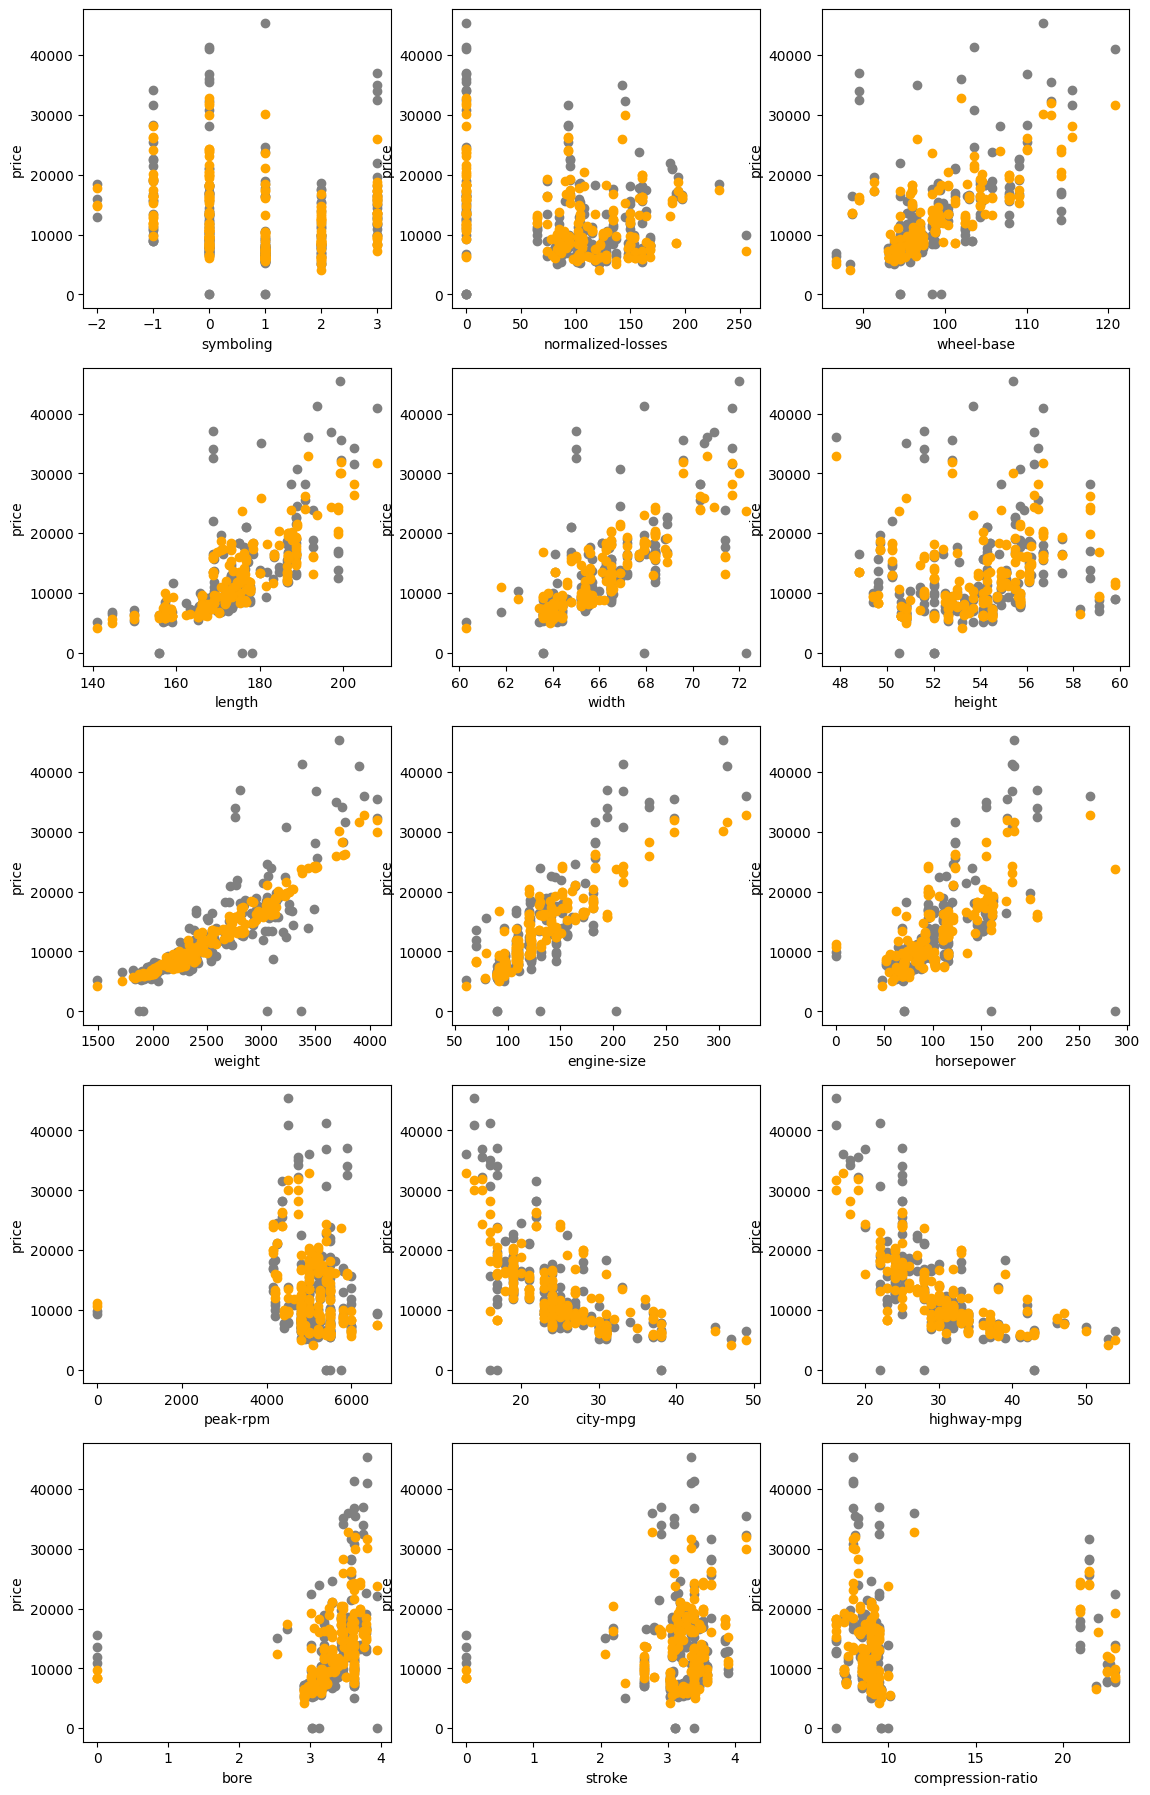

In [ ]:
from matplotlib import pyplot as plt


def scatter_plot_inference_grid(model, x_df, feature_names): # Changed est to model
  """Plots the predictions of the model against each feature.

  Args:
    model: The trained Keras model. # Changed description
    x_df: The pandas dataframe with the input data (used to create
      predict_input_fn).
    feature_names: An iterable of string feature names to plot.
  """
  def scatter_plot_inference(axis,
                             x_axis_feature_name,
                             y_axis_feature_name,
                             predictions):
    """Generate one subplot."""
    # Plot the real data in grey.
    y_axis_feature_name = 'price'
    axis.set_ylabel(y_axis_feature_name)
    axis.set_xlabel(x_axis_feature_name)
    axis.scatter(car_data[x_axis_feature_name],
                 car_data[y_axis_feature_name],
                 c='grey')

    # Plot the predicted data in orange.
    axis.scatter(car_data[x_axis_feature_name], predictions, c='orange')


  predictions = model.predict(x_df[numeric_feature_names]) # Changed to use model.predict

  # For predictions, we need to flatten the output if it's a 2D array
  predictions = predictions.flatten()

  import math # Importing math for ceil function
  num_cols = 3
  num_rows = int(math.ceil(len(feature_names)/float(num_cols)))
  f, axarr = plt.subplots(num_rows, num_cols)
  size = 4.5
  f.set_size_inches(num_cols*size, num_rows*size)

  for i, feature_name in enumerate(numeric_feature_names):
    axis = axarr[int(i/num_cols), i%num_cols]
    scatter_plot_inference(axis, feature_name, 'price', predictions)
  plt.show()

scatter_plot_inference_grid(model, x_df, numeric_feature_names) # Changed est to model

## Task 2: Take your best numeric model from earlier. Add normalization.

### Add normalization to your best numeric model from earlier

- You decide what type of normalization to add, and for which features
- You will need to use the `normalizer_fn` arg on [`numeric_column`](https://g3doc.corp.google.com/learning/brain/public/g3doc/api_docs/python/tf/feature_column/numeric_column.md?cl=head)
    - An example of a silly normalizer_fn that shifts inputs down by 1, and then negates the value:
    
         normalizer_fn = lambda x: tf.neg(tf.subtract(x, 1))

- You may find these pandas functions helpful:
    - dataframe.mean()['your_feature_name']
    - dataframe.std()['your_feature_name']
- You will need to retune the hyperparameters from earlier.


**Does normalization improve model quality on this dataset? Why or why not?**

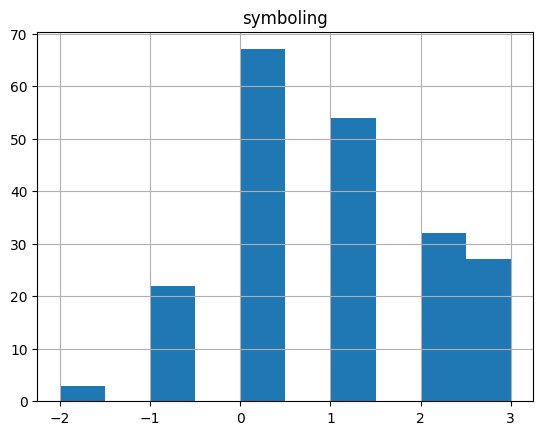

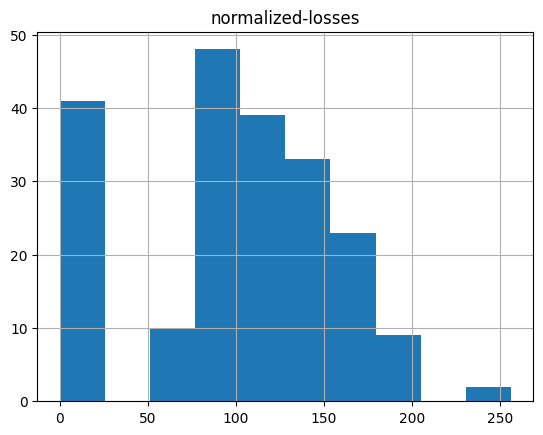

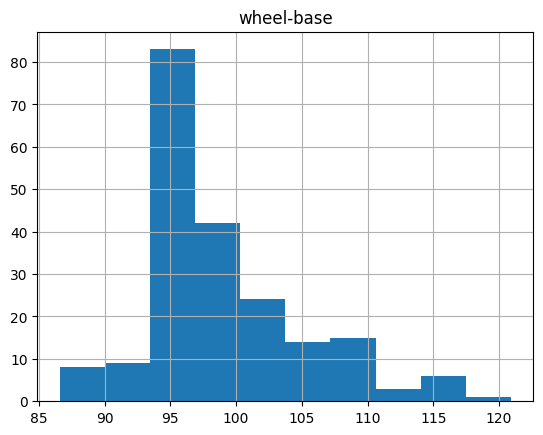

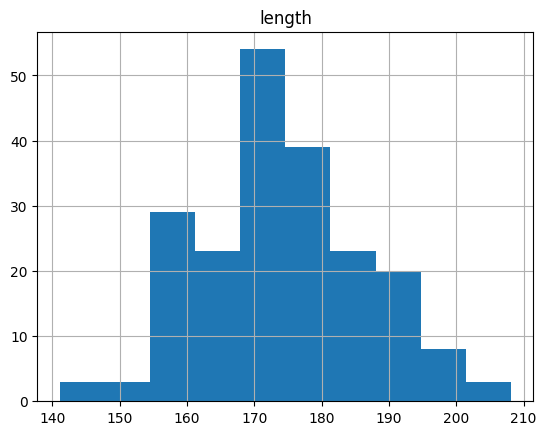

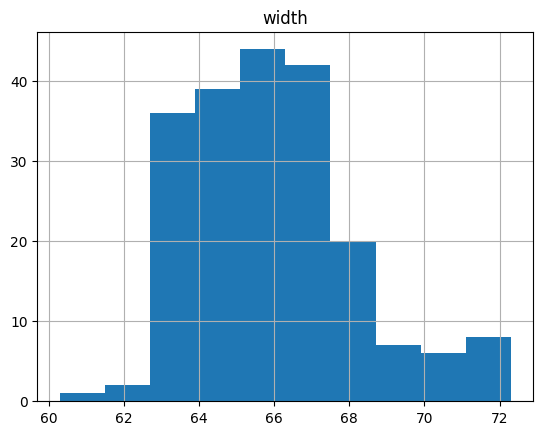

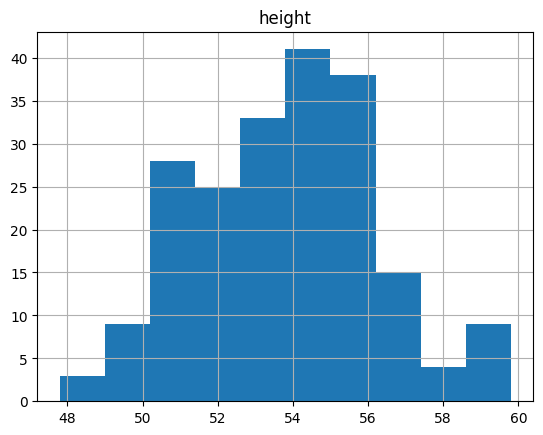

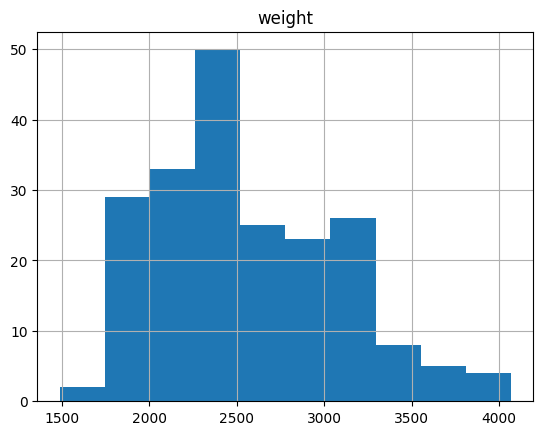

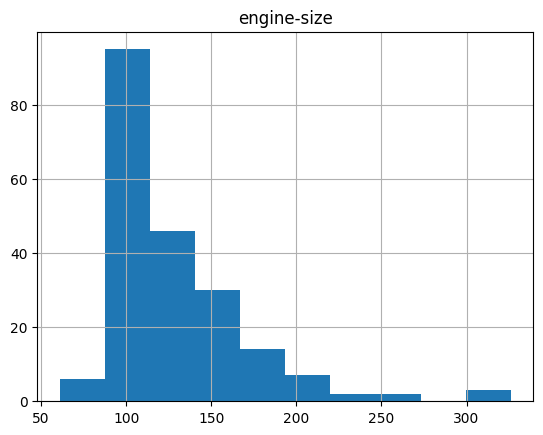

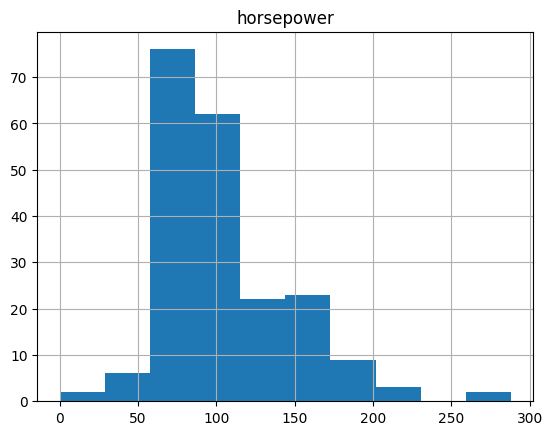

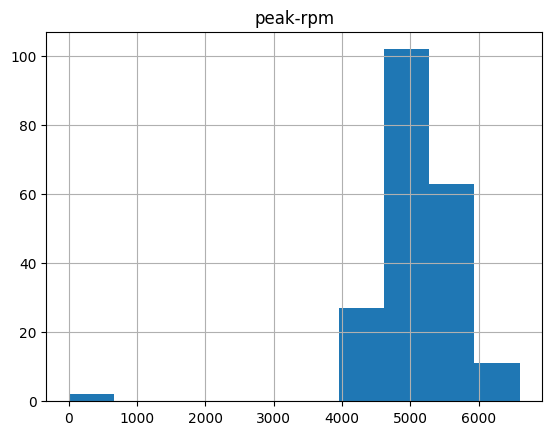

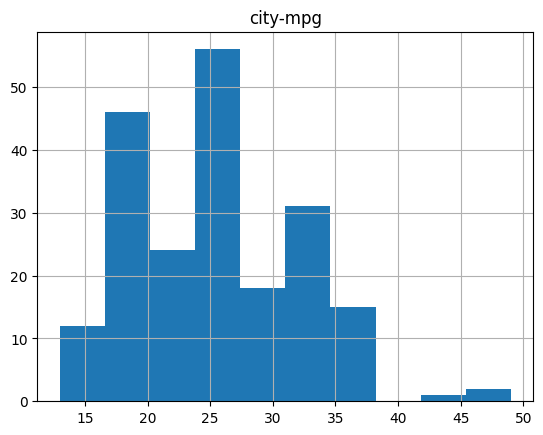

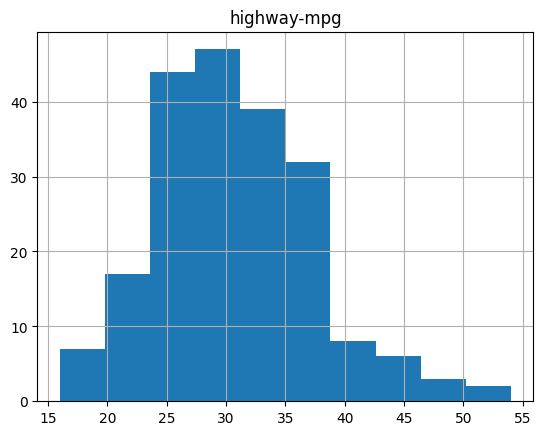

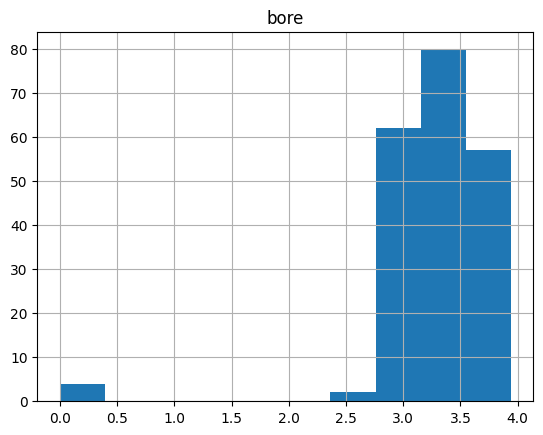

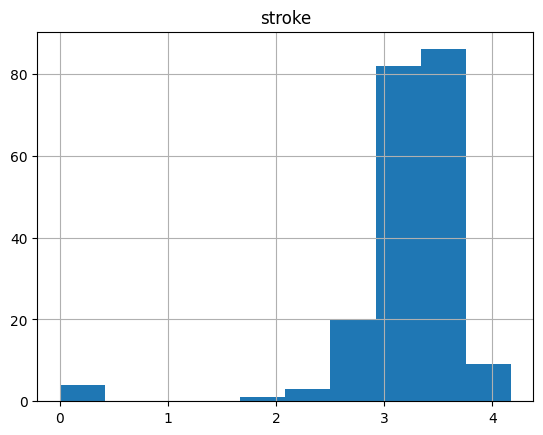

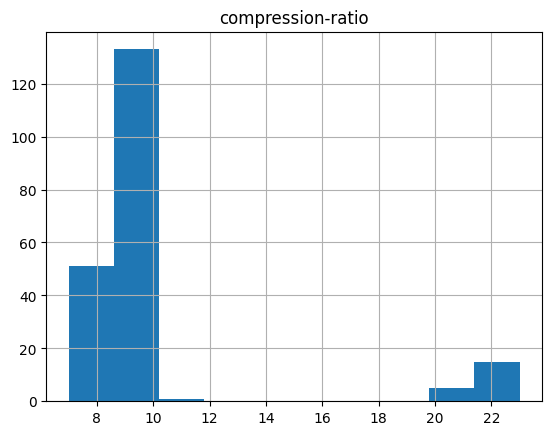

In [ ]:
# This 1D visualization of each numeric feature might inform your normalization
# decisions.
for feature_name in numeric_feature_names:
  car_data.hist(column=feature_name)

###Train your model with numeric features + normalization

In [ ]:
# Define batch size
batch_size = 16

# Prepare data (categorical features remain unnormalized, numeric features normalized inside the model)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Build a more complex DNN model using Keras with normalization, regularization, and dropout
model = tf.keras.Sequential([
    # Add a normalization layer to normalize the input data during training
    layers.Normalization(input_shape=(x_df.shape[1],)),  # Normalize numeric features
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.1),  # Dropout layer to reduce overfitting

    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.1),

    layers.Dense(1)  # Output layer for regression
])

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(
    x_df.values, y_series.values,  # Ensure input is in numpy format
    epochs=100,  # Set epochs to 100
    batch_size=batch_size,
    validation_split=0.2,  # Use 20% of the data for validation
    callbacks=[early_stopping]  # Apply early stopping
)

# Evaluate the model on the test set
eval_dataset = tf.data.Dataset.from_tensor_slices((x_df.values, y_series))
eval_dataset = eval_dataset.batch(batch_size)

# Evaluate the model
loss, mae = model.evaluate(eval_dataset, steps=len(x_df) // batch_size)

print(f"\n✅ Test MSE (Loss): {loss:.2f}")
print(f"✅ Test MAE: {mae:.2f}")


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 243143232.0000 - mae: 13302.4014 - val_loss: 212015408.0000 - val_mae: 12193.5752
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 190404144.0000 - mae: 11590.2090 - val_loss: 182654608.0000 - val_mae: 11008.2090
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 200697536.0000 - mae: 11533.6895 - val_loss: 155139872.0000 - val_mae: 9757.5713
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 142551840.0000 - mae: 9221.7344 - val_loss: 129418264.0000 - val_mae: 8409.7949
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 132997344.0000 - mae: 8443.2109 - val_loss: 105095792.0000 - val_mae: 6918.7422
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 111245264.0000 - mae: 6902.6104 - val_loss: 83911704.0000 - val_mae: 5582.7065
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 85059656.0000 - mae: 5754.0010 - val_loss: 68825792.0000 - val_mae: 4964.0923
Epoch 8/100
11/11 ━━━━━━━━━━━━

## Task 3: Make your best model using only categorical features

- Look at the possible feature columns for categorical features. They begin with `categorical_column_with_` in go/tf-ops.
- You may find `dataframe[categorical_feature_names].unique()` helpful.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
import numpy as np
import pandas as pd
import warnings

# Define batch size
batch_size = 16

# Load the dataset (assuming the car_data is already loaded)
# Clean column names by replacing hyphens with underscores
car_data.columns = car_data.columns.str.replace('-', '_')

# Categorical feature names (use only these features)
categorical_feature_names = ['fuel_type', 'make', 'body_style', 'drive_wheels', 'engine_location']

# Prepare data (only categorical features)
# Include all necessary columns for interaction terms
x_df = car_data[['fuel_type', 'make', 'body_style', 'drive_wheels', 'engine_location']] # Include fuel_type and body_style here
y_series = car_data['price']

# One-Hot Encode categorical features (converts categories into numeric format)
x_df = pd.get_dummies(x_df, drop_first=True)  # Drop first to avoid multicollinearity


# Add interaction terms (Multiply pairs of features, if relevant for categorical features)
# The columns should now be available in x_df
x_df['fuel_type_body_style'] = x_df['fuel_type_gas'] * x_df['body_style_hardtop'] # Update with the actual column names after get_dummies
x_df['make_engine_location'] = x_df['make_audi'] * x_df['engine_location_rear'] # Update with the actual column names after get_dummies


# Add these interaction terms to the model input
categorical_feature_names_with_interactions = x_df.columns.tolist()  # Get updated feature names

# Build a DNN model using Keras with regularization and dropout
model = tf.keras.Sequential([
    tf.keras.Input(shape=(len(categorical_feature_names_with_interactions),)),  # Input layer (shape inferred from data)

    # First hidden layer with 128 neurons and L2 regularization
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),  # Dropout to reduce overfitting

    # Second hidden layer with 64 neurons
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),

    # Third hidden layer with 32 neurons
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),

    # Output layer for regression (single neuron for continuous price prediction)
    layers.Dense(1)
])

# Compile the model with Adam optimizer and MSE loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model with the categorical data and interaction terms
history = model.fit(
    x_df.values, y_series.values,  # Ensure input is in numpy format
    epochs=100,  # Set epochs to 100
    batch_size=batch_size,
    validation_split=0.2,  # Use 20% of the data for validation
    callbacks=[early_stopping]  # Apply early stopping
)

# Evaluate the model on the test set
eval_dataset = tf.data.Dataset.from_tensor_slices((x_df.values, y_series))
eval_dataset = eval_dataset.batch(batch_size)

# Evaluate the model
loss, mae = model.evaluate(eval_dataset, steps=len(x_df) // batch_size)

print(f"\n✅ Test MSE (Loss): {loss:.2f}")
print(f"✅ Test MAE: {mae:.2f}")


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 226851168.0000 - mae: 13060.9697 - val_loss: 227804528.0000 - val_mae: 12774.4424
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 232516624.0000 - mae: 12698.6904 - val_loss: 227792720.0000 - val_mae: 12773.9775
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 247140880.0000 - mae: 13336.8174 - val_loss: 227773472.0000 - val_mae: 12773.2344
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 239492480.0000 - mae: 13125.6064 - val_loss: 227742672.0000 - val_mae: 12772.0596
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 224862000.0000 - mae: 12901.9961 - val_loss: 227694624.0000 - val_mae: 12770.2227
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 251519280.0000 - mae: 13399.1270 - val_loss: 227618688.0000 - val_mae: 12767.3096
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 253741792.0000 - mae: 13372.9258 - val_loss: 227502704.0000 - val_mae: 12762.8428
Epoch 

## Task 4: Using all the features, make the best model that you can make

With all the features combined, your model should perform better than your earlier models using numerical and categorical models alone. Tune your model until that is the case.

In [ ]:
!pip install -U scikit-learn

In [ ]:
!pip install keras

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from tensorflow.keras.optimizers import RMSprop

# Define batch size
batch_size = 16

# Clean column names to replace hyphens with underscores
car_data.columns = car_data.columns.str.replace('-', '_')

# Check the updated column names
print(car_data.columns)

# Define numeric features (ensure these match the actual columns in your dataset)
numeric_feature_names = [
    'symboling', 'normalized_losses', 'wheel_base', 'length', 'width', 'height', 'weight',
    'engine_size', 'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg', 'compression_ratio'
]

# Prepare data (polynomial features for interaction terms)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create polynomial features up to degree 2 (interaction terms included)
poly = PolynomialFeatures(degree=2, interaction_only=False)
x_poly = poly.fit_transform(x_df)

# Update the feature names to include interaction terms
poly_feature_names = poly.get_feature_names_out(input_features=numeric_feature_names)
x_poly_df = pd.DataFrame(x_poly, columns=poly_feature_names)

# Step 2: Set up KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
for train_index, val_index in kf.split(x_poly_df):
    print(f"Training on fold {fold}...")

    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = x_poly_df.iloc[train_index], x_poly_df.iloc[val_index]
    y_train_fold, y_val_fold = y_series.iloc[train_index], y_series.iloc[val_index]

    # Step 3: Define and compile the model architecture
    def create_model(learning_rate=0.001, dropout_rate=0.2, neurons=64):
        model = tf.keras.Sequential([
            tf.keras.Input(shape=(X_train_fold.shape[1],)),
            layers.Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
            layers.Dropout(dropout_rate),
            layers.Dense(neurons * 2, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
            layers.Dropout(dropout_rate),
            layers.Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
            layers.Dense(1)  # Output layer for regression
        ])
        model.compile(optimizer=RMSprop(learning_rate=learning_rate),
                      loss='mean_squared_error', metrics=['mae'])
        return model

    # Step 4: Train the model on each fold
    model = create_model(learning_rate=0.0005, neurons=128, dropout_rate=0.2)
    model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=batch_size, validation_data=(X_val_fold, y_val_fold), verbose=0)

    # Step 5: Evaluate the model on the validation set
    val_loss, val_mae = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Fold {fold} - Validation Loss: {val_loss:.2f}, Validation MAE: {val_mae:.2f}")

    fold += 1

# Step 6: Final Model Training on Full Data (after Cross-Validation)
final_model = create_model(learning_rate=0.0005, neurons=128, dropout_rate=0.2)
final_model.fit(x_poly_df, y_series, epochs=100, batch_size=batch_size, validation_split=0.2, verbose=1)

# Step 7: Evaluate the model on the full dataset (test set not needed here due to cross-validation)
loss, mae = final_model.evaluate(x_poly_df, y_series)
print(f"\n✅ Final Model Test MSE (Loss): {loss:.2f}")
print(f"✅ Final Model Test MAE: {mae:.2f}")


Index(['symboling', 'normalized_losses', 'make', 'fuel_type', 'aspiration',
       'num_doors', 'body_style', 'drive_wheels', 'engine_location',
       'wheel_base', 'length', 'width', 'height', 'weight', 'engine_type',
       'num_cylinders', 'engine_size', 'fuel_system', 'bore', 'stroke',
       'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg',
       'highway_mpg', 'price'],
      dtype='object')
Training on fold 1...
Fold 1 - Validation Loss: 53355372.00, Validation MAE: 4202.61
Training on fold 2...
Fold 2 - Validation Loss: 175175328.00, Validation MAE: 10673.26
Training on fold 3...
Fold 3 - Validation Loss: 28161064.00, Validation MAE: 3931.56
Training on fold 4...
Fold 4 - Validation Loss: 26581432.00, Validation MAE: 3376.23
Training on fold 5...
Fold 5 - Validation Loss: 106504344.00, Validation MAE: 8389.54
Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 2373426348032.0000 - mae: 1214867.7500 - val_loss: 306652151808.0000 - val_mae: 533182.5625
Epoch 2/